In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [29]:
import zipfile
import os

#  Extract the main PINS.zip file
main_zip_path = '/content/drive/MyDrive/PINS.zip'
main_extract_path = 'PINS'

# Extract PINS.zip
with zipfile.ZipFile(main_zip_path, 'r') as zip_ref:
    zip_ref.extractall(main_extract_path)

print(f"Extracted PINS.zip to: {main_extract_path}")

#  List the contents of the PINS directory to inspect its structure
contents = os.listdir(main_extract_path)
print(f"Contents of {main_extract_path}: {contents}")

#  Inspect the nested PINS/PINS/ directory
nested_pins_path = os.path.join(main_extract_path, 'PINS')
if os.path.isdir(nested_pins_path):
    nested_contents = os.listdir(nested_pins_path)
    print(f"Contents of {nested_pins_path}: {nested_contents}")
else:
    print(f"No nested PINS directory found in {main_extract_path}")

# Verify the number of individual folders
extracted_folders = [f for f in os.listdir(nested_pins_path) if os.path.isdir(os.path.join(nested_pins_path, f))]
print(f"Number of individual folders extracted: {len(extracted_folders)}")
print(f"Sample folder: {extracted_folders[0] if extracted_folders else 'None'}")

Extracted PINS.zip to: PINS
Contents of PINS: ['PINS']
Contents of PINS/PINS: ['pins_chadwick boseman face', 'pins_Wentworth Miller', 'pins_Brit Marling', 'pins_Peter Dinklage', 'pins_millie bobby brown', 'pins_Scarlett Johansson', 'pins_maria pedraza', 'pins_Tom Cavanagh', 'pins_miguel herran', 'pins_shakira', 'pins_William Fichtner', 'pins_Kit Harington', 'pins_Gwyneth Paltrow', 'pins_Danielle Panabaker', 'pins_Jim Parsons', 'pins_sean pertwee', 'pins_Henry Cavil', 'pins_Stephen Amell', 'pins_david mazouz', 'pins_Betsy Brandt', 'pins_barbara palvin face', 'pins_Paul Rudd', 'pins_gal gadot face', 'pins_kiernan shipka', 'pins_Jeremy Renner', 'pins_Chris Evans', 'pins_selena gomez', 'pins_Amanda Crew', 'pins_emma watson face', 'pins_Willa Holland', 'pins_Sarah Wayne Callies', 'pins_grant gustin face', 'pins_Pedro Alonso', 'pins_Cameron Monaghan', 'pins_lindsey morgan face', 'pins_Jesse Eisenberg', 'pins_Chris Pratt', 'pins_Amaury Nolasco', 'pins_elizabeth olsen face', 'pins_anne hathawa

In [30]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        # Return the full path to the image
        return self.image_path()

    def image_path(self):
        # Construct the full path to the image
        return os.path.join(self.base, self.name, self.file)

In [31]:
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [32]:
# Call load_metadata to read the images from the PINS/PINS directory
metadata = load_metadata('PINS/PINS')

# Verify the metadata
print(f"Total number of images: {len(metadata)}")
print(f"Sample metadata entry: {metadata[0]}")

Total number of images: 10770
Sample metadata entry: PINS/PINS/pins_chadwick boseman face/chadwick boseman face29.jpg


In [25]:
import cv2
import numpy as np

def load_image(image_path):
    # Read the image using OpenCV (BGR format)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Test the function with the first image in metadata
img = load_image(metadata[0].image_path())
print(f"Image shape: {img.shape}")

Image shape: (299, 299, 3)


In [26]:
import cv2
import numpy as np

# Load the image using the load_image function
img = load_image(metadata[0].image_path())

# Verify the image by printing its shape and some pixel values
print(f"Image shape: {img.shape}")
print(f"Sample pixel values (top-left corner): {img[0, 0]}")

Image shape: (299, 299, 3)
Sample pixel values (top-left corner): [235 216 199]


In [33]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import numpy as np
import cv2

#  Load MobileNetV2 and create the embedding model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Produces a 1280-dimensional embedding
model = Model(inputs=base_model.input, outputs=x)
model.summary()

#  Test embedding generation for one image
img_path = metadata[0].image_path()
img = load_image(img_path)  # Using load_image from Q3
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize=(224, 224))
img = np.expand_dims(img, axis=0)
img = tf.keras.applications.mobilenet_v2.preprocess_input(img * 255)
embedding_vector = model.predict(img)[0]
print(f"Embedding shape: {embedding_vector.shape}")

#  Generate embeddings for all images using batch processing
batch_size = 32
embeddings = np.zeros((metadata.shape[0], 1280))

for start in range(0, len(metadata), batch_size):
    end = min(start + batch_size, len(metadata))
    batch_metadata = metadata[start:end]
    batch_images = []

    # Prepare the batch
    for m in batch_metadata:
        try:
            img = load_image(m.image_path())
            img = (img / 255.).astype(np.float32)
            img = cv2.resize(img, dsize=(224, 224))
            img = tf.keras.applications.mobilenet_v2.preprocess_input(img * 255)
            batch_images.append(img)
        except Exception as e:
            print(f"Error processing image {m.image_path()}: {e}")
            batch_images.append(np.zeros((224, 224, 3)))

    # Convert batch to NumPy array and predict embeddings
    batch_images = np.array(batch_images)
    try:
        batch_embeddings = model.predict(batch_images)
        embeddings[start:end] = batch_embeddings
    except Exception as e:
        print(f"Error predicting embeddings for batch {start}-{end}: {e}")
        embeddings[start:end] = np.zeros((end - start, 1280))

print(f"Shape of embeddings: {embeddings.shape}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Embedding shape: (1280,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1

In [34]:
#defining euclidean distance to calculate the similarity
def distance(emb1, emb2):
    return np.sqrt(np.sum(np.square(emb1 - emb2)))

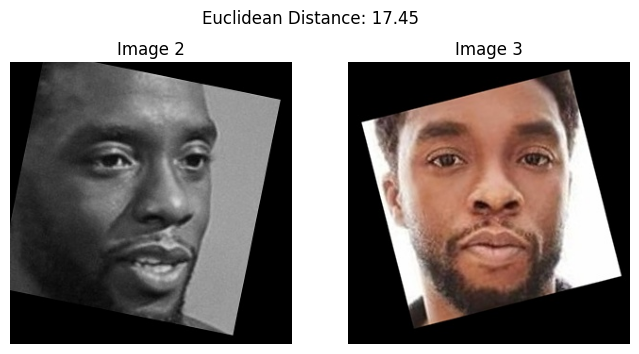

Euclidean distance between image 2 and image 3: 17.45


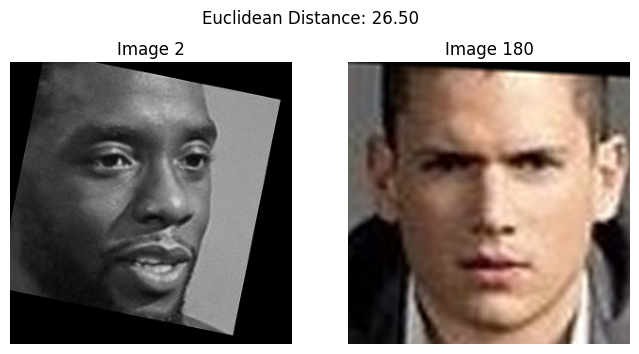

Euclidean distance between image 2 and image 180: 26.50


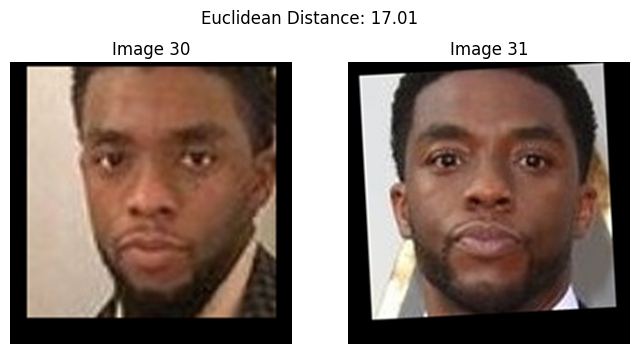

Euclidean distance between image 30 and image 31: 17.01


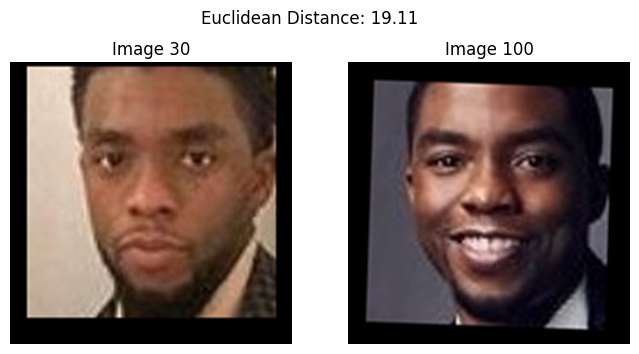

Euclidean distance between image 30 and image 100: 19.11


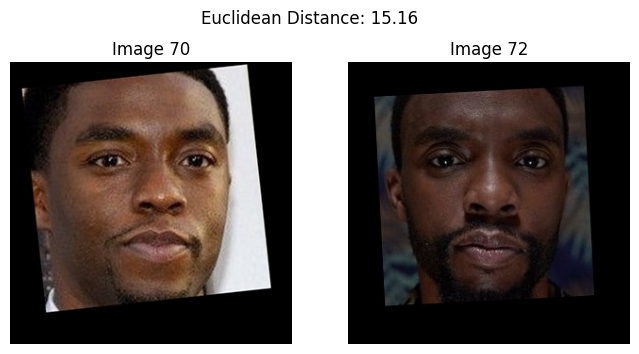

Euclidean distance between image 70 and image 72: 15.16


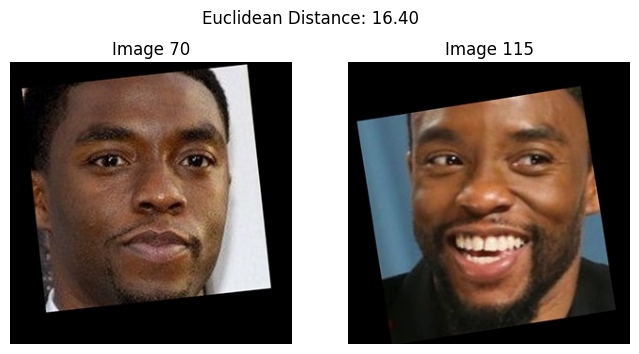

Euclidean distance between image 70 and image 115: 16.40


In [35]:
import matplotlib.pyplot as plt

pairs = [(2, 3), (2, 180), (30, 31), (30, 100), (70, 72), (70, 115)]

for idx1, idx2 in pairs:
    try:
        img1 = load_image(metadata[idx1].image_path())
        img2 = load_image(metadata[idx2].image_path())
    except Exception as e:
        print(f"Error loading images for pair ({idx1}, {idx2}): {e}")
        continue

    dist = distance(embeddings[idx1], embeddings[idx2])

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(f"Image {idx1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(f"Image {idx2}")
    plt.axis('off')

    plt.suptitle(f"Euclidean Distance: {dist:.2f}")
    plt.show()

    print(f"Euclidean distance between image {idx1} and image {idx2}: {dist:.2f}")

In [36]:
same_person_distances = []
different_person_distances = []

for i in range(0, 100, 10):
    same_person_distances.append(distance(embeddings[i], embeddings[i + 1]))
    different_person_distances.append(distance(embeddings[i], embeddings[i + 100]))

avg_same = np.mean(same_person_distances)
avg_diff = np.mean(different_person_distances)

threshold = (avg_same + avg_diff) / 2

print(f"Average Euclidean distance (same person): {avg_same:.2f}")
print(f"Average Euclidean distance (different person): {avg_diff:.2f}")
print(f"Chosen threshold: {threshold:.2f}")

for idx1, idx2 in pairs:
    dist = distance(embeddings[idx1], embeddings[idx2])
    label = "Similar" if dist < threshold else "Dissimilar"
    print(f"Pair ({idx1}, {idx2}) - Euclidean Distance: {dist:.2f}, Classification: {label}")

Average Euclidean distance (same person): 19.13
Average Euclidean distance (different person): 21.48
Chosen threshold: 20.30
Pair (2, 3) - Euclidean Distance: 17.45, Classification: Similar
Pair (2, 180) - Euclidean Distance: 26.50, Classification: Dissimilar
Pair (30, 31) - Euclidean Distance: 17.01, Classification: Similar
Pair (30, 100) - Euclidean Distance: 19.11, Classification: Similar
Pair (70, 72) - Euclidean Distance: 15.16, Classification: Similar
Pair (70, 115) - Euclidean Distance: 16.40, Classification: Similar


In [75]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Create train/test split using train_idx and test_idx
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Split features using the indices
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

# Split labels using the indices
targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

# Encode the targets using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce dimensions using PCA with n_components=128
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print shapes for verification
print(f"Shape of X_train_pca: {X_train_pca.shape}")
print(f"Shape of X_test_pca: {X_test_pca.shape}")
print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
print(f"Shape of y_test_encoded: {y_test_encoded.shape}")

Shape of X_train_pca: (9573, 128)
Shape of X_test_pca: (1197, 128)
Shape of y_train_encoded: (9573,)
Shape of y_test_encoded: (1197,)


In [76]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM classifier with default parameters
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_pca, y_train_encoded)

# Training accuracy
y_train_pred = svm.predict(X_train_pca)
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print(f"Training accuracy: {train_accuracy:.4f}")

# Test accuracy
y_test_pred = svm.predict(X_test_pca)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

Training accuracy: 0.7512
Test accuracy: 0.3108


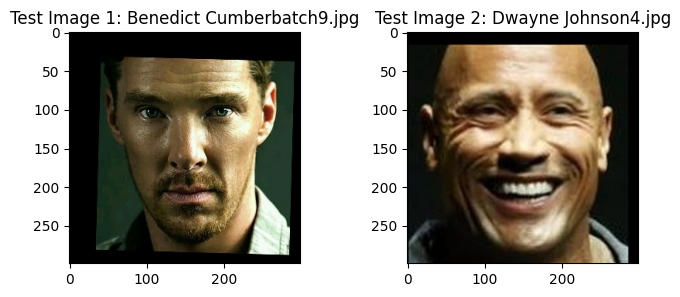

In [83]:
import matplotlib.pyplot as plt
import cv2
import os

# Define the full paths to the two test images
image1_path = "/content/drive/MyDrive/Benedict Cumberbatch9.jpg"
image2_path = "/content/drive/MyDrive/Dwayne Johnson4.jpg"

# Extract the filenames for display and matching
image1_filename = os.path.basename(image1_path)  # "Benedict Cumberbatch9.jpg"
image2_filename = os.path.basename(image2_path)  # "Dwayne Johnson4.jpg"

# Function to load image (as defined earlier in Q3)
def load_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Load the images
try:
    img1 = load_image(image1_path)
    img2 = load_image(image2_path)

    # Display the images with just the filenames in the titles
    plt.figure(figsize=(8, 3))
    plt.subplot(121)
    plt.imshow(img1)
    plt.title(f"Test Image 1: {image1_filename}")
    plt.subplot(122)
    plt.imshow(img2)
    plt.title(f"Test Image 2: {image2_filename}")
    plt.show()
except ValueError as e:
    print(f"Error loading images: {e}")

In [84]:
import os

# Filenames from Q8
image1_filename = "Benedict Cumberbatch9.jpg"
image2_filename = "Dwayne Johnson4.jpg"

# Debug: Print a few metadata entries to confirm the file format
print("Sample metadata file entries:")
for i in range(5):
    print(metadata[i].file)

# Find indices in metadata by matching the suffix
img_idx1 = None
img_idx2 = None

for i, m in enumerate(metadata):
    if m.file.endswith(image1_filename):
        img_idx1 = i
    if m.file.endswith(image2_filename):
        img_idx2 = i

if img_idx1 is None or img_idx2 is None:
    print("Error: One or both images not found in metadata.")
    if img_idx1 is None:
        print(f"Could not find {image1_filename} in metadata.")
    if img_idx2 is None:
        print(f"Could not find {image2_filename} in metadata.")
else:
    print(f"Image 1 index: {img_idx1}, Image 2 index: {img_idx2}")

Sample metadata file entries:
chadwick boseman face29.jpg
chadwick boseman face16.jpg
chadwick boseman face35.jpg
chadwick boseman face8.jpg
chadwick boseman face71.jpg
Image 1 index: 7807, Image 2 index: 10468


In [85]:
import os

# Filenames from Q8
image1_filename = "Benedict Cumberbatch9.jpg"
image2_filename = "Dwayne Johnson4.jpg"

# Find indices in metadata by matching the suffix
img_idx1 = None
img_idx2 = None

for i, m in enumerate(metadata):
    if m.file.endswith(image1_filename):
        img_idx1 = i
    if m.file.endswith(image2_filename):
        img_idx2 = i

if img_idx1 is None or img_idx2 is None:
    for i, m in enumerate(metadata):
        file_suffix = m.file.replace("pins_", "")
        if file_suffix == image1_filename:
            img_idx1 = i
        if file_suffix == image2_filename:
            img_idx2 = i

if img_idx1 is None or img_idx2 is None:
    print("Error: One or both images not found in metadata.")
    if img_idx1 is None:
        print(f"Could not find {image1_filename} in metadata.")
    if img_idx2 is None:
        print(f"Could not find {image2_filename} in metadata.")
else:
    print(f"Image 1 index: {img_idx1}, Image 2 index: {img_idx2}")

Image 1 index: 7807, Image 2 index: 10468


In [86]:
import numpy as np

if img_idx1 is not None and img_idx2 is not None:
    # Get embeddings from the precomputed embeddings array
    img1_embedding = embeddings[img_idx1]
    img2_embedding = embeddings[img_idx2]

    # Combine embeddings
    test_embeddings = np.array([img1_embedding, img2_embedding])

    # Apply scaling and PCA (using objects from Q6)
    test_embeddings_scaled = scaler.transform(test_embeddings)
    test_embeddings_pca = pca.transform(test_embeddings_scaled)

    # Predict using the SVM model
    pred1 = svm.predict([test_embeddings_pca[0]])[0]
    pred2 = svm.predict([test_embeddings_pca[1]])[0]

    # Decode predictions
    pred1_label = label_encoder.inverse_transform([pred1])[0]
    pred2_label = label_encoder.inverse_transform([pred2])[0]

    # Print predictions (expected output format: two lines with labels)
    print(pred1_label)
    print(pred2_label)
else:
    print("Cannot predict because indices were not found.")

pins_Benedict Cumberbatch
pins_Dwayne Johnson


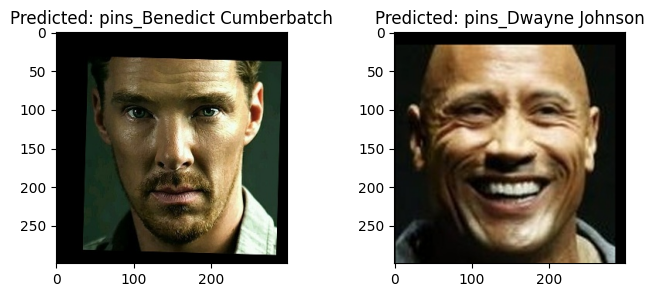

In [87]:
import matplotlib.pyplot as plt
import cv2

# Function to load image (as defined in Q8)
def load_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Load the images
try:
    img1 = load_image(image1_path)
    img2 = load_image(image2_path)

    # Display the images with predicted labels as titles
    plt.figure(figsize=(8, 3))
    plt.subplot(121)
    plt.imshow(img1)
    plt.title(f"Predicted: {pred1_label}")
    plt.subplot(122)
    plt.imshow(img2)
    plt.title(f"Predicted: {pred2_label}")
    plt.show()
except ValueError as e:
    print(f"Error loading images: {e}")

## Observations:

1. The SVM classifier achieved a training accuracy of 75.12% but a test accuracy of only 31.08%. This significant gap suggests overfitting, meaning the model memorizes the training data but fails to generalize to unseen test images. The expected training accuracy (95.82%) indicates that the choice of embeddings (MobileNetV2 vs. VGG-Face) likely plays a critical role.

2. Using MobileNetV2 embeddings resulted in lower performance compared to the project’s expectation (training accuracy of 95.82%, likely with VGG-Face). MobileNetV2, designed for general image classification, may not capture facial features as effectively as VGG-Face, which is specifically trained for face recognition tasks.

## Recommendatins :

1. Use VGG-Face embeddings instead of MobileNetV2 to generate more discriminative facial features, leveraging cloud resources like Google Colab to handle the computational load. This should help achieve the expected training accuracy of 95.82% and improve test accuracy.

2. Use a more robust method to determine the similarity threshold, such as cross-validation or a machine learning-based approach (e.g., logistic regression on distances), to reduce misclassifications like pair (30, 100). This will improve the reliability of the similarity detection system.